In [1]:
import glob
import pandas as pd
import email
import numpy as np
import matplotlib.pyplot as plt
from email import policy
from src.parser.MailTextParser import parse_mime_tree
from src.parser.MailSubjectParser import parse_mime_subject
from src.parser.MailSenderParser import parse_mime_sender
from typing import Dict, List, Optional, Tuple, Union, Literal
from collections import Counter
import re
import spacy
from typing import Optional, List, Dict, Union, Literal

# Übersicht
<small>Version: 1.0.0 (28.12.2024)</small>

Dieses Jupyter Notebook enthält den Code für die Analyse der Beiträge auf der Yggdrasill Mailing-Liste.

Folgende Schritte wurden bisher umgesetzt:

1. Laden der E-Mail-Daten (eml Format) aus Thunderbird und Transformation plus Cleaning.
2. Datenanalyse
   1. Betreffszeilen-Analyse
   2. Autoren-Analyse
   3. Text-Analyse
   4. Beitragshäufigkeiten-Analyse
3. Visualisierungen
    1. Beiträge/Jahr
    2. Beiträge/Monat (in einem bestimmten Jahr)

## Hilfsfunktionen


In [ ]:
MONTH_MAPPING = {
    "01": "JAN",
    "02": "FEB",
    "03": "MAR",
    "04": "APR",
    "05": "MAI",
    "06": "JUN",
    "07": "JUL",
    "08": "AUG",
    "09": "SEP",
    "10": "OCT",
    "11": "NOV",
    "12": "DEC"
}

In [ ]:
def guess_encoding(file_path: str) -> Optional[Literal['utf-8', 'iso-8859-1', 'windows-1252']]:
    '''
    Guess the encoding of a file.

    Parameters
    ----------
        file_path: str
            Path to the file.

    Returns
    -------
        Optional[Literal['utf-8', 'iso-8859-1', 'windows-1252']]
            Returns either the encoding or None if no encoding matches the file format.
    '''
    encodings = ['utf-8', 'iso-8859-1', 'windows-1252']  # Add more as needed
    for enc in encodings:
        try:
            with open(file_path, encoding=enc) as file:
                content = file.read()
                if content == None:
                    print("NONE")
                return enc
        except UnicodeDecodeError:
            continue
    print(f"Could not open {file_path}. Maybe wrong encoding?")
    return None

## Hauptfunktionen
Wir erstellen ein Dictionary mit allen Informationen der E-Mails aus einer gewählten Jahres-Range.

In [ ]:
def get_emails_from_folder(year_range: Tuple[int,int]) -> Dict[int, Dict[str, Dict[int, email.message.Message]]]:
    '''
    Get all emails from email folders stored under data/.

    Parameters
    ----------
        year_range: Tuple(int,int)
            The year range, where starting year is _inclusive_ and end year is _exclusive_.

    Returns
    -------
        (Dict) 
        
        {
            YEAR: {
                MONTH: {
                    1: <email.message.Message>
                }
                ...
            }
        }
    '''
    emails = dict()
    counter = 0
    for year in range(year_range[0],year_range[1]):
        emails[year] = dict()
        for month in MONTH_MAPPING:
            emails[year][month] = dict()
            for idx, file in enumerate(glob.glob(f"data/{year}/yggdrasill_{year}-{month}/*")):
                # Guess encoding first, since there are quite a few non-UTF-8 mails
                enc = guess_encoding(file)
                with open(file, "r", encoding=enc) as f:
                    emails[year][month][idx] = email.message_from_file(f, policy=policy.default) # The policy-default is very important for subject titles
                    # Check if message has been parsed correctly
                    if emails[year][month][idx].keys() == []:
                        print(f"Issue with mail!")
                        print(file)                            
                counter += 1
    print(f"Received {counter} emails from {year_range[0]} to {year_range[1]-1}.") 
    return emails

In [ ]:
#emails_all = get_emails_from_folder((1997,2025))

In [ ]:
#emails_2024 = get_emails_from_folder((2024,2025))

## Speichern & Laden der E-Mails

In [ ]:
### Save data locally so that get_emails_from_folder() does not have to run twice
import pickle

#with open("storage_all.pkl", "wb") as f:
    #pickle.dump(emails_all, f)

#with open("storage_2024.pkl", "wb") as f:
    #pickle.dump(emails_2024, f)

In [2]:
# Open data
import pickle

#with open("storage_all.pkl", "rb") as f:
 #   emails_all = pickle.load(f)

with open("storage_2024.pkl", "rb") as f:
    emails_2024 = pickle.load(f)

## Datenerzeugung aus E-Mails

In [3]:
def get_content_from_emails(email_dict: Dict[int, Dict[str, Dict[int, email.message.Message]]]) -> Dict:
    '''
    Extract CONTENT, SUBJECT, SENDER from emails retrieved via get_emails_from_folder().

    Parameters
    ----------
        email_dict: Dict[str, Dict[str, Dict[int, email.message.Message]]
            The dictionary with emails, retrieved using get_emails_from_folder().

    Returns
    -------
        (Dict) 
        
        {
            YEAR: {
                MONTH: {
                    1: {
                        "subject": "<SUBJECT>",
                        "text": "<TEXT>",
                        "sender": "<SENDER>"
                    }
                    ...
                    "counter": <INT>
                }
                ...
                "counter": <INT>
            }
            "counter": <INT>
        }
    '''
    emails = dict()
    counter = 0
    for year in email_dict:
        counter_year = 0
        emails[year] = dict()
        for month in email_dict[year]:
            counter_month = 0
            emails[year][month] = dict()
            for idx, mail in email_dict[year][month].items():
                text = parse_mime_tree(mail)
                sender = parse_mime_sender(mail)
                subject = parse_mime_subject(mail)
                emails[year][month][idx] = {
                    "text": text,
                    "subject": subject,
                    "sender": sender
                }
                # Incrementing counters
                counter += 1
                counter_year += 1
                counter_month += 1
            emails[year][month]["counter"] = counter_month
        emails[year]["counter"] = counter_year
    emails["counter"] = counter
    return emails

In [4]:
#content = get_content_from_emails(emails_all)

In [5]:
content_2024 = get_content_from_emails(emails_2024)

## Analyse

### Betreffszeilen-Analyse

In [ ]:
def clean_subject(subject: str) -> str:
    '''
    Function to clean an email-subject using RE.

    Parameters
    ----------
        subject: str
            The raw e-mail subject that should be cleaned.

    Returns
    -------
        str
            The clean e-mail subject.
    '''
    CLEANING_PATTERN = re.compile(r"^re:\s+\[ygg\]|^fwd:\s+\[ygg\]|^aw:\s+\[ygg\]|^re:\s+fwd:\s+\[ygg\]|^\[ygg\]|\baw:|\bfwd:|\bfw:|\bre:|\[dolmen\]|\[candide\]", re.IGNORECASE)
    subject = re.sub(CLEANING_PATTERN, " ", subject)
    subject = re.sub(r"\s{2,}", " ", subject)
    subject = subject.strip().lower()
    return subject

In [ ]:
## Get titles related to conferences and cfps

def get_specific_subjects(emails_in: Dict, pattern: re) -> Dict[int, Dict[str,Union[List,int]]]:
    '''
    Function to count and collect all subjects matching a RE pattern.

    Parameters
    ----------
        emails_in: Dict
            The nested content dict from get_content_from_emails().
        pattern: re
            The RE to match.

    Returns
    -------
        Dictionary:
        {
            <YEAR>: {
                "titles": List[str],
                "counter": int
            }
            counter = int
        }
    '''
    cfp_dict = dict()
    # Create general counter for all years
    cfp_dict["counter"] = 0
    for year,months in emails_in.items():
        if type(year) == int:
            cfp_dict[year] = {
                "titles": list(),
                "counter": 0
            }
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_subject = clean_subject(msg["subject"]) if msg["subject"] else ""
                            if re.match(pattern, cln_subject):
                                cfp_dict[year]["titles"].append(msg["subject"])
                                cfp_dict[year]["counter"] += 1
                                cfp_dict["counter"] += 1

    return cfp_dict           

In [ ]:
## Get titles related to conferences and cfps

def get_top_subjects(emails_in) -> Counter:
    '''Function to count and collect all subjects.

        Parameters
        ----------
            emails_in: Dict[]
                The nested content dict from get_content_from_emails().

        Returns
        -------
            Counter: Counter() object with frequency of cleaned subjects.
    '''
    counter = Counter()
    for year,months in emails_in.items():
        if type(year) == int:
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_subject = clean_subject(msg["subject"]) if msg["subject"] else ""
                            counter[cln_subject] += 1

    # Remove empty subject lines
    if "" in counter:
        del counter[""]
    return counter

In [ ]:
CFP_RE_PATTERN = re.compile(r"cfa|cfp|konferenz|conference|call for paper(s)?|tagung")
ANNOUNCEMENTS_RE_PATTERN = re.compile(r"ankündigung|publikation|publication|bekanntmachung|announcement")

# Add content dict to analyze here
CONTENT = content_2024

# Calc stats for topics
cfp_subjects_dict = get_specific_subjects(CONTENT, CFP_RE_PATTERN)
ann_subjects_dict = get_specific_subjects(CONTENT, ANNOUNCEMENTS_RE_PATTERN)
top_subjects = get_top_subjects(CONTENT)
print(f"Von {CONTENT['counter']:,} Nachrichten waren {cfp_subjects_dict['counter']} ({(cfp_subjects_dict['counter']/ CONTENT['counter'])*100:.2f}%) Call for Papers und {ann_subjects_dict['counter']} ({(ann_subjects_dict['counter']/ CONTENT['counter'])*100:.2f}%) Ankündigungen (Bücher, Veranstaltungen usw.).")

In [ ]:
top_subjects.most_common(10)

In [ ]:
# Gesamtverteilung Beiträge/Monat
# Save the month with most posts per year
top_month_dict = dict()
for year, months in content.items():
    if year != "counter":
        total_sum_year = content[year]["counter"]
        top_month = ""
        top_month_counter = 0
        for month in months:
            if month != "counter":
                relative_posts = months[month]["counter"]/total_sum_year
                if relative_posts > top_month_counter:
                    top_month_counter = relative_posts
                    top_month = month
        top_month_dict[year] = top_month

In [ ]:
top_months_cnt = Counter(top_month_dict.values())

### Text-Analyse
Dieser Teil konzentriert sich auf die Analyse des Nachrichteninhalts einer Auswahl von Nachrichten. Mit der Methode `get_messages_from_specific_subjects()` kann erst eine Auswahl an E-Mails basierend auf einem RE.match der Überschriften erstellt werden. Die Daten für die ausgewählten Mails umfassen:

1. Eine lemmatisierte Version des Textes (in Kleinbuchstaben gesetzt, nur alphabetische Wörter).
2. Eine Liste mit NEs (*named entitites*) und den NE-Kategorien, die in den Nachrichten vorkommen.

Die Analyse besteht in einem BOW der lemmatisierten Nachrichten via `bow()` und einer Auswertung der NEs via `ner()`.

Leider sind diese Analysen noch sehr schwierig auszuwerten. So kommen viele Orte, Namen und Phrasen ("Wenn Sie keine Mails mehr erhalten möchten...", "Yggdrasill" etc.) nur so häufig vor, weil sich der Inhalt von E-Mails durch Zitate in anderen E-Mails wiederholt oder weil Orte bzw. Institutionen wie "Universität Graz" von beteiligten Personen in einer Signatur unter den Beiträgen verwendet werden. Diese sagen aber noch nichts über das eigentliche Thema aus.


In [ ]:
def clean_text(text: str, nlp) -> Tuple[str, List[str]]:
    '''Function to clean text (message from email) using spaCy and more. Also returns lists of NER.

        Parameters
        ----------
            text: in
                The message from the email.
            nlp: spaCy pipeline
                The spaCy pipeline for the text processing.

        Returns
        -------
            Clean text string.
    '''
    text = nlp(text)
    # lemmata
    lemmata = [token.lemma_ for token in text if token.is_alpha and not token.is_stop]
    lemmata = [lemma.lower() for lemma in lemmata]
    # ners
    ner = [(token.text.lower(), token.label_) for token in text.ents]
    return (" ".join(lemmata), ner)

In [ ]:
def get_messages_from_specific_subjects(emails_in, pattern) -> Dict[int, Dict[str,Union[List,int]]]:
    '''Function to count and collect all messages from emails with subjects matching a RE pattern.

        Parameters
        ----------
            emails_in: Dict[]
                The nested content dict from get_content_from_emails().
            pattern: re
                The RE to match.

        Returns
        -------
            Dictionary:
            {
                <YEAR>: {
                    "messages": List[str],
                    "counter": int
                    "ner": List[Tuple[str,str]]
                }

                counter: int
            }
    '''
    cfp_dict = dict()
    # Create general counter for all years
    cfp_dict["counter"] = 0
    # Create spaCy pipeline to pass to clean_text() later
    nlp = spacy.load("de_core_news_md")
    for year,months in emails_in.items():
        if type(year) == int:
            cfp_dict[year] = {
                "messages": list(),
                "counter": 0,
                "ner": list()
            }
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_subject = clean_subject(msg["subject"]) if msg["subject"] else ""
                            if re.search(pattern, cln_subject):
                                # Only get clean text
                                text, ner = clean_text(msg["text"], nlp)
                                cfp_dict[year]["messages"].append(text)
                                cfp_dict[year]["ner"].extend(ner)
                                cfp_dict[year]["counter"] += 1
                                cfp_dict["counter"] += 1

    return cfp_dict      

In [ ]:
def bow(messages_dict: dict) -> Counter:
    '''Function to create a simple bag-of-words Counter() from a dictionary with messages from emails.
    '''
    cnt = Counter()
    for year,data in messages_dict.items():
        if type(year) == int:
            for k,v in data.items():
                if k == "messages":
                    for text in v:
                        cnt.update(text.split())
    return cnt
    

In [ ]:
def ner_analysis(messages_dict: dict) -> Tuple[Counter]:
    '''Function to analyze list of ners in dictionary created with get_messages_from_specific_subjects().
    '''
    cnt_text = Counter()
    cnt_label = Counter()
    for year,data in messages_dict.items():
        if type(year) == int:
            for k,v in data.items():
                if k == "ner":
                    for tpl in v:
                        cnt_text.update([tpl[0]])
                        cnt_label.update([tpl[1]])
    return (cnt_text, cnt_label)

In [ ]:
# Get specific subject
spec_sub_dict = get_messages_from_specific_subjects(CONTENT, re.compile(r"wissenschaftsfreiheit und antisemitismus"))

In [ ]:
# Saving the messages for external corpus linguistics
def store_messages_for_corpus_linguistics(messages_list: List[str], filename: str = "messages4cl.txt") -> None:
    '''
    Saves messages locally in a file where each message is a single line.

    Parameters
    ----------
        messages_list: List[str]
            The list of messages (emails).

        filename: str, optional
            The filename, default is "messages4cl.txt".

    Returns
    -------
        None
    '''
    with open(filename, "w", encoding="utf-8") as f:
        for msg in messages_list:
            f.write(msg+"n")

In [ ]:
store_messages_for_corpus_linguistics(spec_sub_dict[2024]["messages"])

In [ ]:
#bow(spec_sub_dict)

In [ ]:
#ner_analysis(spec_sub_dict)

### Autoren-Analyse

In [6]:
def clean_sender(sender: str) -> str:
    '''Function to clean an email-from field using RE.
    '''
    SEARCH_PATTERN = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", re.IGNORECASE)
    sender_clean = re.findall(SEARCH_PATTERN, sender)
    sender_clean = sender_clean[0].strip().lower() if len(sender_clean) > 0 else ""
    if sender_clean == "yggdrasill@lists.uni-marburg.de":
        # If the sender was the mailing list, try and find the name of the sender instead of email
        # Should not be necessary any more since X-Original-From field is now also parsed from .eml files
        sender_clean = re.findall(r'^.*?[(<]', sender)
        sender_clean = sender_clean[0].strip().lower() if len(sender_clean) > 0 else ""
        sender_clean = re.sub(r"\W+", " ", sender_clean)
        sender_clean = re.sub(r"\s{2,}", " ", sender_clean)
    return sender_clean.strip()

In [7]:
def get_top_sender(emails_in) -> Counter:
    '''Function to count and collect sender.

        Parameters
        ----------
            emails_in: Dict
                The nested content dict from get_content_from_emails().

        Returns
        -------
            Counter: Counter() object with frequency of cleaned sender data.
    '''
    counter = Counter()
    for year,months in emails_in.items():
        if type(year) == int:
            for month,messages in months.items():
                if month != "counter":
                    for _,msg in messages.items():
                        if _ != "counter":
                            cln_sender = clean_sender(msg["sender"]) if msg["sender"] else ""
                            counter[cln_sender] += 1
    return counter
                    
                

In [8]:
sender_counter = get_top_sender(content_2024)

In [13]:
#sender_counter.most_common(10)

In [16]:
def plot_cumsum_author_posts(posts: List[int]):
    # Sortiere Liste mit Beitragsanzahl absteigend
    posts = sorted(posts)[::-1]
    # Berechne die kumulative Summe
    cumulative_sum = np.cumsum(posts)
    # Erstelle den Plot
    plt.figure(figsize=(8, 5))  # Größe des Diagramms
    plt.plot(range(1, len(posts)+1), cumulative_sum, linestyle='-', color='b')
    
    # Beschriftungen und Titel hinzufügen
    plt.xlabel('% Beitragende (absteigend nach Beiträgen)')
    plt.ylabel('Kumulative Summe d. Beiträge')
    plt.title('Yggdrasill Beiträge 2024')

    # Gitterlinien hinzufügen (optional)
    plt.grid(True)

    # X-Ticks ausblenden
    x_ticks = [0, len(posts)//4, len(posts)//2, len(posts)//4*3, len(posts)]
    x_labels = ["0%", "25%", "50%", "75%", "100%"]
    plt.xticks(x_ticks, x_labels)
    
    # Anzeigen des Plots
    plt.savefig("cumsum_2024.png")
    plt.show()

In [17]:
posts_desc = list()

for _,v in sender_counter.items():
    posts_desc.append(v)

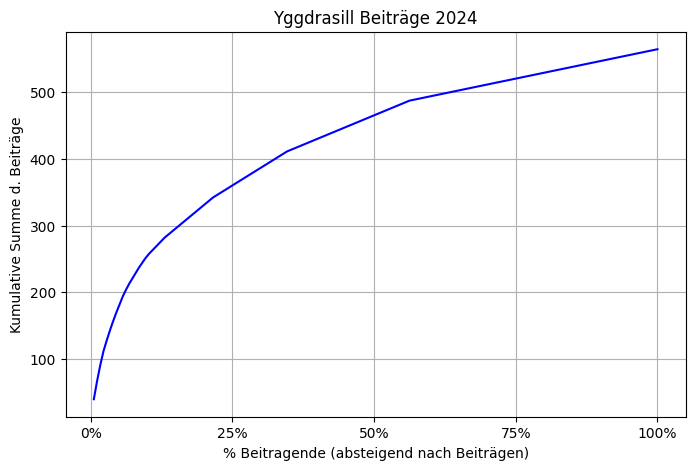

In [18]:
plot_cumsum_author_posts(posts_desc)

In [9]:
# Anzahl Sender
len(sender_counter)

176

In [28]:
from openai import OpenAI

def get_gender(email_address: str)  -> Union[Literal["w"],Literal["m"],Literal["e"]]:
    '''Function to predict if a given email address belongs to a) man b) woman c) else (institution etc.).
    Using OpenAI API for prediction.
    '''
    
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a minimalistic assistant, skilled in predicting whether an email address belongs to a woman, man or else. For woman, you respond w, for man you respond m, and for else with e. So your response has only one character!"},
            {"role": "user", "content": f"{email_address}"}
        ]
    )

    return completion.choices[0].message.content
    

In [24]:
def predict_gender_from_emails(sender_counter: Counter) -> dict:
    '''Function to predict gender from email addresses via get_gender().
    '''
    email_gender_dict = dict()
    for name,_ in sender_counter.items():
        pred = get_gender(name)
        email_gender_dict[name] = pred

    return email_gender_dict
    

In [25]:
def sender_gender_distro(sender_dict, mapping: dict) -> Counter():
    '''Function to calculate m/w/e ration of Ygg-participations.
    '''
    cnt = dict()
    cnt["w"] = 0
    cnt["m"] = 0
    cnt["e"] = 0
    for name,posts in sender_dict.items():
        gender = mapping[name]
        cnt[gender] += posts
    return cnt

In [26]:
dic_ = predict_gender_from_emails(sender_counter)

In [37]:
# save predictions
#with open("sender_gender_2024.pkl", "wb") as f:
    #pickle.dump(dic_, f)

In [38]:
# load predictions
with open("sender_gender_2024.pkl", "rb") as f:
    dic_ = pickle.load(f)

In [39]:
# Manually check if gender is okay
#for email, gender in dic_.items():
    print(email)
    print(gender)
    feedback = input("Change?")
    if feedback in ["e","w","m"]:
        print("Changed!")
        dic_[email] = feedback

IndentationError: unexpected indent (1932170615.py, line 3)

In [41]:
sg_dict = sender_gender_distro(sender_counter, dic_)

In [45]:
sg_dict

{'w': 218, 'm': 307, 'e': 39}

In [53]:
sg_sum = sg_dict["w"] + sg_dict["m"] + sg_dict["e"]

print(f'{(sg_dict["w"]/sg_sum)*100:.2f}% der Diskussionsteilnehmenden waren weiblich, {(sg_dict["m"]/sg_sum)*100:.2f}% männlich und {(sg_dict["e"]/sg_sum)*100:.2f}% unbekannt (Funktionsadressen, Institutionen etc.).')

38.65% der Diskussionsteilnehmenden waren weiblich, 54.43% männlich und 6.91% unbekannt (Funktionsadressen, Institutionen etc.).


In [55]:
def pie_chart(labels: List[str], sizes: List[float]) -> None:

    # Farben für die Abschnitte
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']
    
    # Explodieren eines oder mehrerer Abschnitte
    explode = (0.01, 0, 0)
    
    # Erstellen des Pie Charts
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=140)
    
    plt.title('Yggdrasill Gender-Analyse 2024')
    
    # Anzeigen des Pie Charts
    plt.axis('equal') 

    plt.savefig("gender_pie.png")
    plt.show()

In [56]:
labels = ["M", "W", "E"]
sizes = [54.43, 38.65, 6.91]

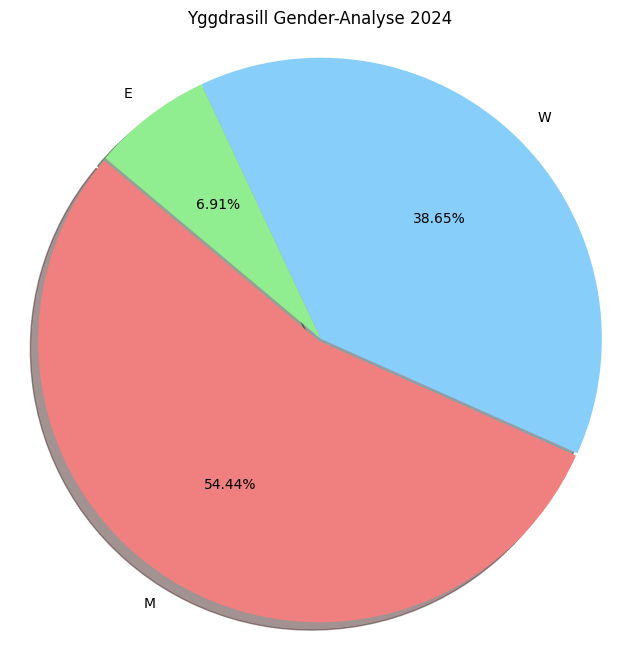

In [57]:
pie_chart(labels, sizes)

### Visualisierungen

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a line plot with enhanced styling
sns.set_style("whitegrid")  # Set the background style
sns.set_palette("viridis")  # Set the color palette

def plot_posts_per_year(emails):
    '''Function to plot the number of posts per year.
    
    '''
    dict_ = dict()
    for year,data in emails.items():
        if type(year) == int:
            dict_[str(year)] = data["counter"]
    df = pd.DataFrame(dict_.items(), columns=["Jahr", "Beiträge"])
    sns.lineplot(x=df["Jahr"], y=df["Beiträge"], marker='o', markersize=8, linestyle='-', linewidth=2)
    plt.title(f"Yggdrasill Beiträge/Jahr 1997-heute", fontsize=16)
    plt.xlabel("Jahr", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylabel("Beiträge", fontsize=13)
    plt.ylim(0, df["Beiträge"].max()+200)
    plt.tight_layout()
    plt.savefig(f"yearly_stats.png")
    

In [ ]:
plot_posts_per_year(content)

In [ ]:
def plot_posts_in_year(emails, year: int):
    '''Function to plot the number of posts/month of a particular year.
    
    '''
    dict_ = dict()
    for month,data in emails[year].items():
        if month != "counter":
            dict_[MONTH_MAPPING[month]] = data["counter"]
    df = pd.DataFrame(dict_.items(), columns=["Monat", "Beiträge"])
    sns.lineplot(x=df["Monat"], y=df["Beiträge"], marker='o', markersize=8, linestyle='-', linewidth=2)
    plt.title(f"Yggdrasill Beiträge/Monat {year}", fontsize=16)
    plt.xlabel("Monat", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylabel("Beiträge", fontsize=13)
    plt.ylim(0, df["Beiträge"].max()+20)
    plt.tight_layout()
    plt.savefig(f"posts_in_{year}.png")
    

In [ ]:
plot_posts_in_year(content,2024)

In [ ]:
def plot_top_months(cnt_dict: Counter):
    '''Function to plot how often each month had most posts in a year.
    
    '''
    dict_ = dict()
    for month,data in cnt_dict.items():
        dict_[MONTH_MAPPING[month]] = data
    df = pd.DataFrame(dict_.items(), columns=["Monat", "Meiste Beiträge"])
    # Definieren der korrekten Reihenfolge der Monate & sortiere anschließend
    monate_order = ["JAN", "FEB", "MAR", "APR", "MAI", "JUN",
                    "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]    
    df["Monat"] = pd.Categorical(df["Monat"], categories=monate_order, ordered=True)
    df = df.sort_values("Monat")
    sns.barplot(x=df["Monat"], y=df["Meiste Beiträge"])
    plt.title(f"Monate mit den meisten Beiträgen (1997-2024)", fontsize=16)
    plt.xlabel("Monat", fontsize=13)
    plt.xticks(rotation=45)
    plt.ylabel("Meiste Beiträge", fontsize=13)
    plt.tight_layout()
    plt.savefig(f"top_months.png")
    

In [ ]:
plot_top_months(top_months_cnt)

In [ ]:
top_months_cnt.items()